In [1]:
import numpy as np
from scipy.io import wavfile
import soundfile as sf
from scipy import signal
from resampy import resample
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    (  0 / 255, 145 / 255, 189 / 255), # blue
    (149 / 255, 214 / 255,   0 / 255), # green
    (255 / 255, 107 / 255,   0 / 255), # orange
    
    
    (255 / 255, 199 / 255,   0 / 255), # yellow
    (  0 / 255, 193 / 255, 222 / 255), # light blue
    (  0 / 255,  43 / 255,  73 / 255), # dark blue
    ( 51 / 255,  62 / 255,  72 / 255), # dark grey
    (125 / 255, 134 / 255, 140 / 255), # grey
    (229 / 255, 236 / 255, 235 / 255), # light gray
])

/var/folders/1g/912b41091855kd9w5h7bz27c0000gn/T/ipykernel_36515/3971289496.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
# params
sample_rate = 16000
period  = 1
amplitude = 0.985
phase = 0
frequency = 1000
window_size = 256

In [3]:
# signal
from cmsisdsp import arm_float_to_q15, arm_float_to_q31, arm_float_to_q7

samples = amplitude*np.sin(2*np.pi*frequency*np.arange(period*sample_rate)/sample_rate)[:window_size]
samples_q15 = arm_float_to_q15(samples)
samples_q31 = arm_float_to_q31(samples)


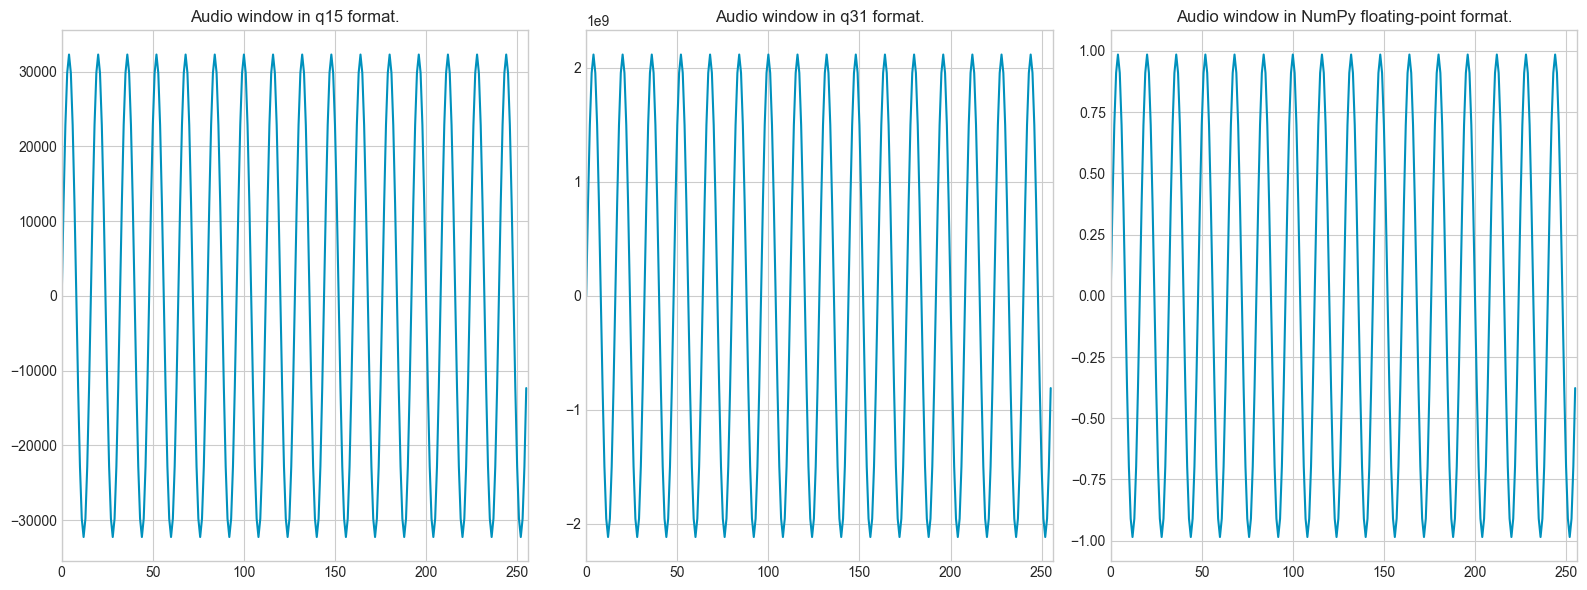

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(samples_q15)
axes[0].set_title("Audio window in q15 format.")
axes[0].set_xlim([0, window_size])

axes[1].plot(samples_q31)
axes[1].set_title("Audio window in q31 format.")
axes[1].set_xlim([0, window_size])

axes[2].plot(samples)
axes[2].set_title("Audio window in NumPy floating-point format.")
axes[2].set_xlim([0, window_size])

fig.tight_layout()

In [5]:
# window
from cmsisdsp import arm_cos_f32, arm_float_to_q15
from cmsisdsp import arm_float_to_q31, arm_float_to_q7

hanning_window = np.hanning(window_size)
hanning_window_f32 = np.zeros(window_size)
hanning_window_np = np.zeros(window_size, dtype=np.float32)
    
for i in range(window_size):
    hanning_window_f32[i] = 0.5 * (1 - arm_cos_f32(2 * np.pi * i / window_size ))
    hanning_window_np[i] = 0.5 * (1 - np.cos(2 * np.pi * i / window_size))
    
hanning_window_q15 = arm_float_to_q15(hanning_window_f32)
hanning_window_q31 = arm_float_to_q31(hanning_window_f32)

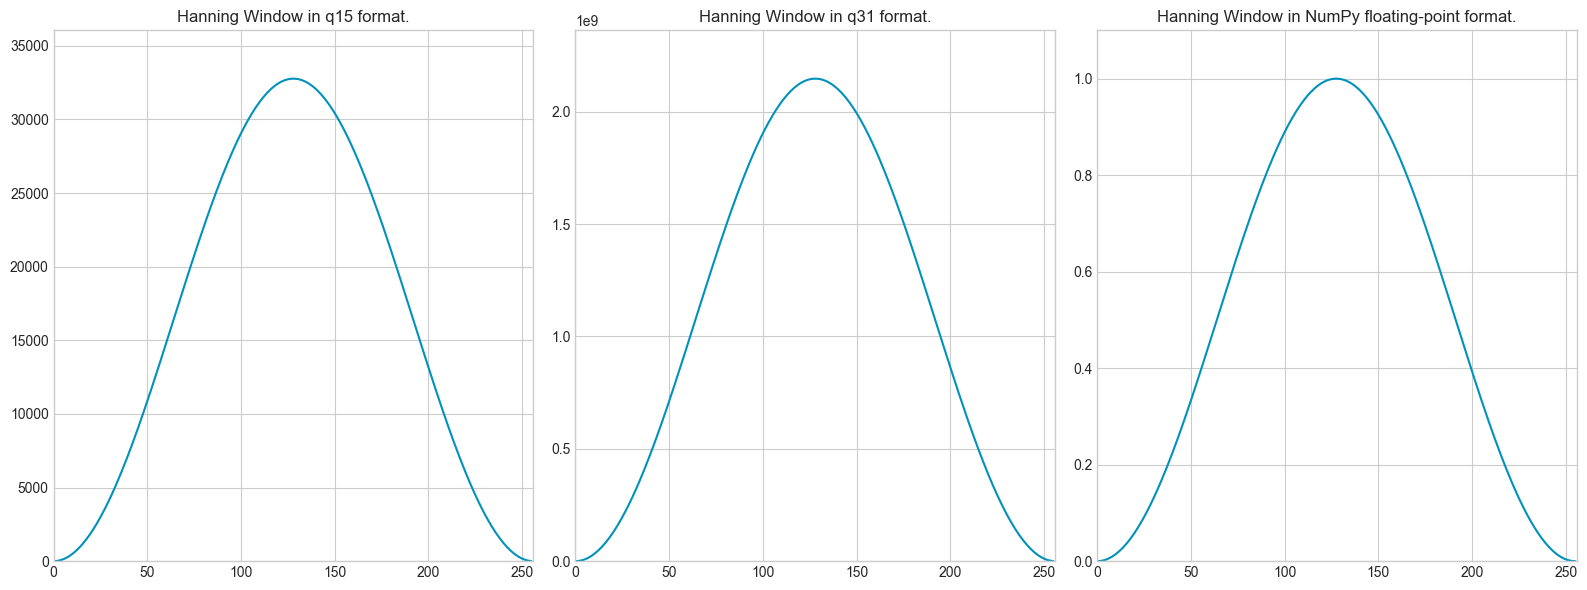

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(hanning_window_q15)
axes[0].set_title("Hanning Window in q15 format.")
axes[0].set_xlim([0, window_size])
axes[0].set_ylim([0, 2**15 * 1.1]) # Q1.15

axes[1].plot(hanning_window_q31)
axes[1].set_title("Hanning Window in q31 format.")
axes[1].set_xlim([0, window_size])
axes[1].set_ylim([0, 2**31 * 1.1]) # Q 1.31

axes[2].plot(hanning_window)
axes[2].set_title("Hanning Window in NumPy floating-point format.")
axes[2].set_xlim([0, window_size])
axes[2].set_ylim([0, 1.1])

fig.tight_layout()

In [7]:
from cmsisdsp import arm_mult_q15, arm_mult_q31

# Multiply the signal by the window
processed_window = samples*hanning_window
processed_window_q15 = arm_mult_q15(samples_q15, hanning_window_q15)
processed_window_q31 = arm_mult_q31(samples_q31, hanning_window_q31)

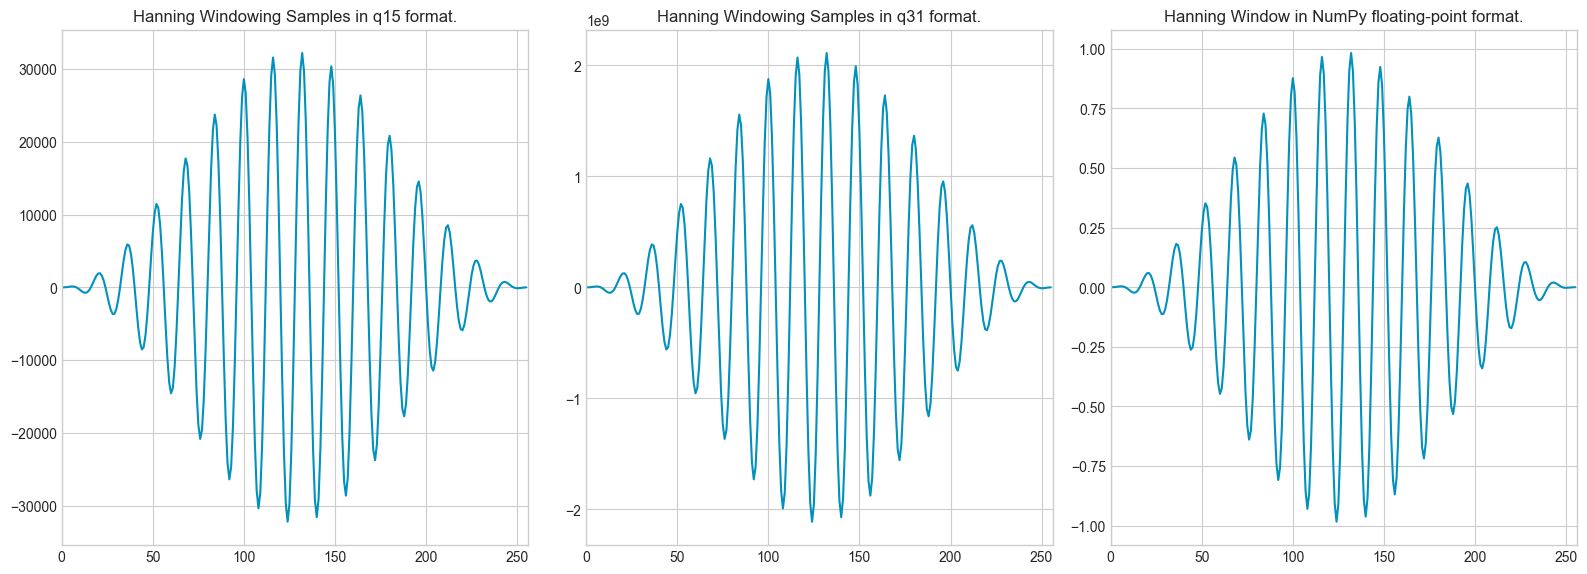

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(processed_window_q15)
axes[0].set_title("Hanning Windowing Samples in q15 format.")
axes[0].set_xlim([0, window_size])
# axes[0].set_ylim([0, 2**15 * 1.1]) # Q1.15

axes[1].plot(processed_window_q31)
axes[1].set_title("Hanning Windowing Samples in q31 format.")
axes[1].set_xlim([0, window_size])
# axes[1].set_ylim([0, 2**31 * 1.1]) # Q 1.31

axes[2].plot(processed_window)
axes[2].set_title("Hanning Window in NumPy floating-point format.")
axes[2].set_xlim([0, window_size])
# axes[2].set_ylim([0, 1.1])

fig.tight_layout()

In [9]:
# numpy fft
# Calculate the FFT.
fft_1 = np.fft.rfft(processed_window)
rfft_float_half = np.zeros(fft_1.shape[0]*2, dtype=np.float32)
rfft_float_half[0::2], rfft_float_half[1::2]= fft_1.real, fft_1.imag

ifft_1 = np.fft.irfft(fft_1)
# Take the absolute value.
fft_bins_1 = np.absolute(fft_1)

In [10]:
from cmsisdsp import arm_rfft_instance_q15, arm_rfft_init_q15, arm_rfft_q15, arm_cmplx_mag_q15
# from cmsisdsp import arm_rfft_instance_q7, arm_rfft_init_q7, arm_rfft_q7, arm_cmplx_mag_q7 # Not implmented yet!
from cmsisdsp import arm_rfft_instance_q31, arm_rfft_init_q31, arm_rfft_q31, arm_cmplx_mag_q31

# Initialize the FFT
"""
[in,out]	S	points to an instance of the Q15 RFFT/RIFFT structure
    [in]	fftLenReal	length of the FFT
    [in]	ifftFlagR	flag that selects transform direction
        value = 0: forward transform
        value = 1: inverse transform
    [in]	bitReverseFlag	flag that enables / disables bit reversal of output
        value = 0: disables bit reversal of output
        value = 1: enables bit reversal of output
"""
ifftFlagR = 0
bitReverseFlag = 1

rfft_instance_q15 = arm_rfft_instance_q15()
status = arm_rfft_init_q15(rfft_instance_q15, window_size, ifftFlagR, bitReverseFlag)

# rfft_instance_q7 = arm_rfft_instance_q7()
# status = arm_rfft_init_q7(rfft_instance_q15, window_size, ifftFlagR, bitReverseFlag)

rfft_instance_q31 = arm_rfft_instance_q31()
status = arm_rfft_init_q31(rfft_instance_q31, window_size, ifftFlagR, bitReverseFlag)

# Apply the FFT to the audio
rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_window_q15) # window 2**8 Q1.15 -> Q 8.8
# rfft_q7 = arm_rfft_q7(rfft_instance_q7, processed_window_q7)
rfft_q31 = arm_rfft_q31(rfft_instance_q31, processed_window_q31) # window 2**8 Q1.31 -> Q 8.24

# Take the absolute value
fft_bins_q15 = arm_cmplx_mag_q15(rfft_q15)[:window_size // 2 + 1] # Q 9.7
# fft_bins_q7 = arm_cmplx_mag_q7(rfft_q7)[:window_size // 2 + 1]
fft_bins_q31 = arm_cmplx_mag_q31(rfft_q31)[:window_size // 2 + 1] # Q 9.23

fft_bins_q15 = fft_bins_q15 
fft_bins_q31 = fft_bins_q31

xf = np.fft.rfftfreq(len(processed_window_q15), d=1./sample_rate)

rfft_q15_half = rfft_q15[:window_size*2]
rfft_q31_half = rfft_q31[:window_size*2]

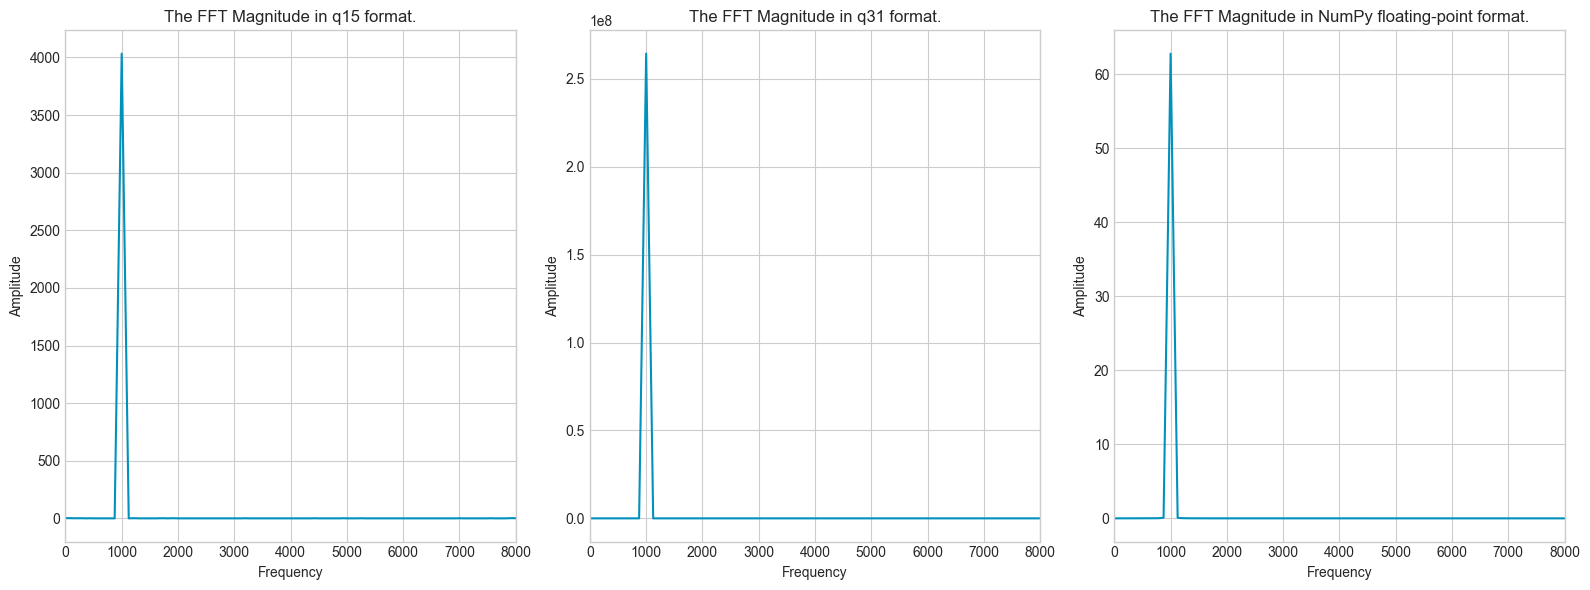

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(xf, fft_bins_q15)
axes[0].set_xlabel("Frequency")
axes[0].set_xlim([xf[0], xf[-1]])
axes[0].set_ylabel("Amplitude")
axes[0].set_title("The FFT Magnitude in q15 format.")

axes[1].plot(xf, fft_bins_q31)
axes[1].set_xlabel("Frequency")
axes[1].set_xlim([xf[0], xf[-1]])
axes[1].set_ylabel("Amplitude")
axes[1].set_title("The FFT Magnitude in q31 format.")

axes[2].plot(xf, fft_bins_1)
axes[2].set_xlabel("Frequency")
axes[2].set_xlim([xf[0], xf[-1]])
axes[2].set_ylabel("Amplitude")
axes[2].set_title("The FFT Magnitude in NumPy floating-point format.")

fig.tight_layout()

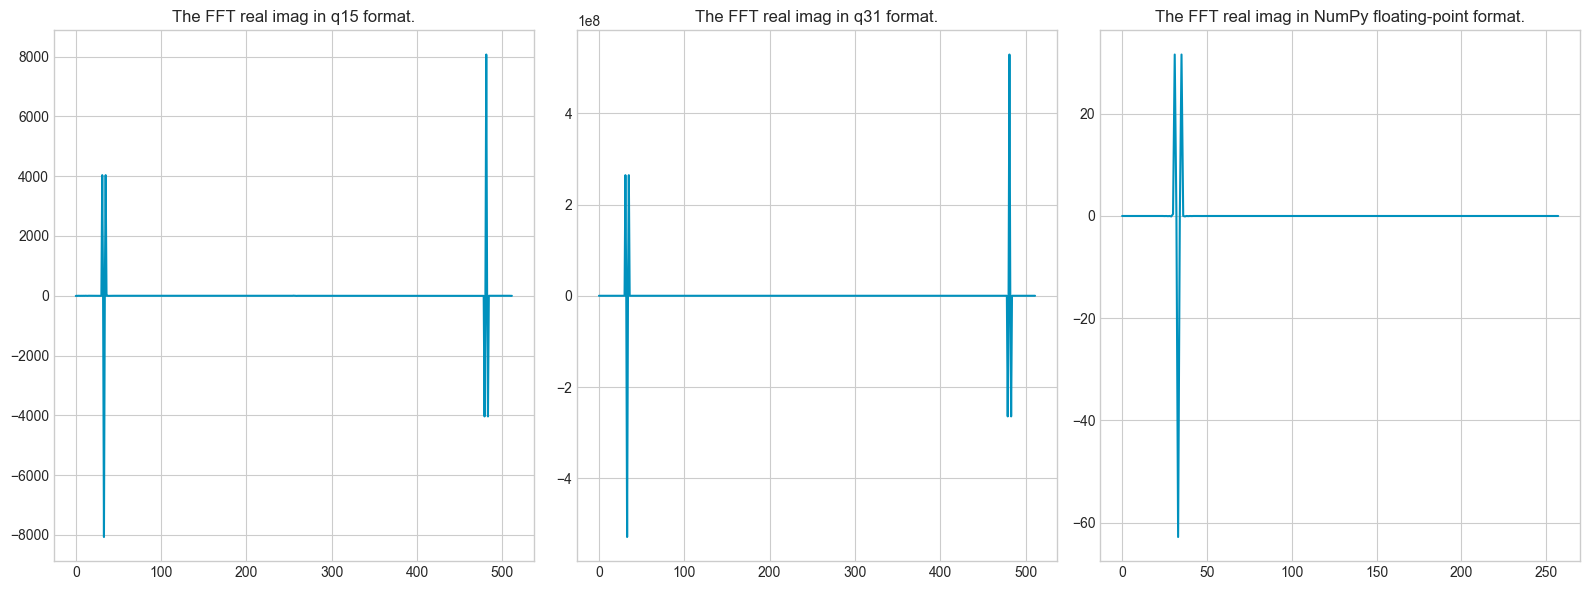

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(rfft_q15_half)
axes[0].set_title("The FFT real imag in q15 format.")

axes[1].plot(rfft_q31_half)
axes[1].set_title("The FFT real imag in q31 format.")

axes[2].plot(rfft_float_half)
axes[2].set_title("The FFT real imag in NumPy floating-point format.")

fig.tight_layout()

In [13]:
from cmsisdsp import arm_q15_to_float, arm_q31_to_float

rfft_q15_half_scaled = arm_q15_to_float(rfft_q15_half) * 2**7
rfft_q31_half_scaled = arm_q31_to_float(rfft_q31_half) * 2**7

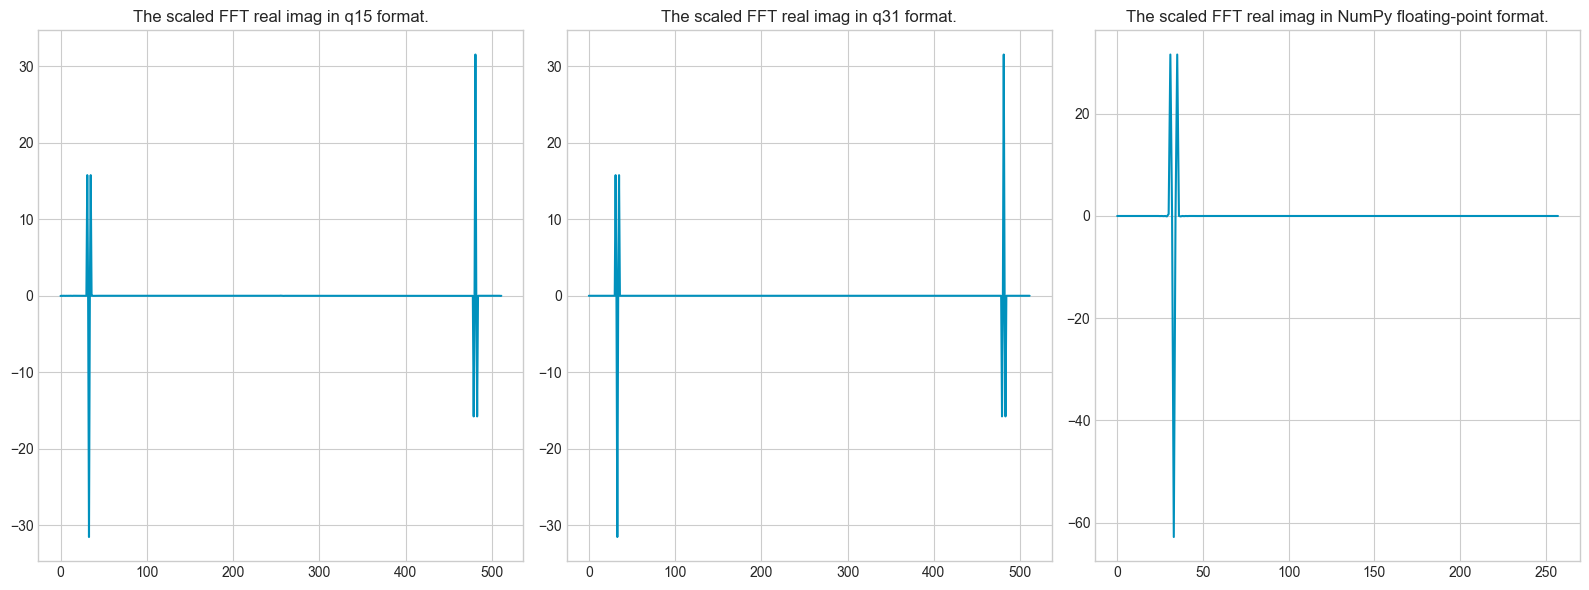

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(rfft_q15_half_scaled)
axes[0].set_title("The scaled FFT real imag in q15 format.")

axes[1].plot(rfft_q31_half_scaled)
axes[1].set_title("The scaled FFT real imag in q31 format.")

axes[2].plot(rfft_float_half)
axes[2].set_title("The scaled FFT real imag in NumPy floating-point format.")

fig.tight_layout()

In [15]:
from cmsisdsp import arm_q15_to_float, arm_q31_to_float

fft_bins_q15_scaled = arm_q15_to_float(fft_bins_q15) * 2**8 # scaled: pDst[n] = (float32_t) pSrc[n] / 32768
fft_bins_q31_scaled = arm_q31_to_float(fft_bins_q31) * 2**8

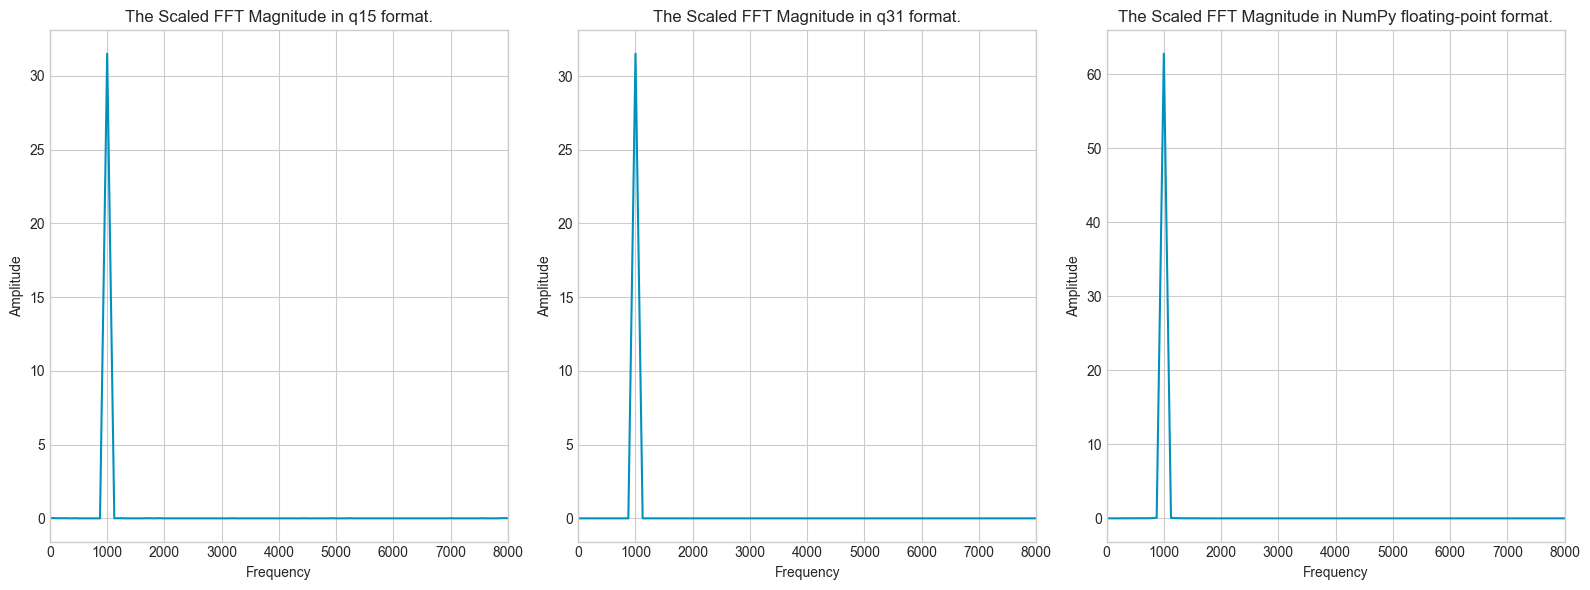

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(xf, fft_bins_q15_scaled) # Half of rfft
axes[0].set_xlabel("Frequency")
axes[0].set_xlim([xf[0], xf[-1]])
axes[0].set_ylabel("Amplitude")
axes[0].set_title("The Scaled FFT Magnitude in q15 format.")

axes[1].plot(xf, fft_bins_q31_scaled)
axes[1].set_xlabel("Frequency")
axes[1].set_xlim([xf[0], xf[-1]])
axes[1].set_ylabel("Amplitude")
axes[1].set_title("The Scaled FFT Magnitude in q31 format.")

axes[2].plot(xf, fft_bins_1)
axes[2].set_xlabel("Frequency")
axes[2].set_xlim([xf[0], xf[-1]])
axes[2].set_ylabel("Amplitude")
axes[2].set_title("The Scaled FFT Magnitude in NumPy floating-point format.")

fig.tight_layout()

In [17]:
# ifft

# Initialize the iFFT
"""
[in,out]	S	points to an instance of the Q15 RFFT/RIFFT structure
    [in]	fftLenReal	length of the FFT
    [in]	ifftFlagR	flag that selects transform direction
        value = 0: forward transform
        value = 1: inverse transform
    [in]	bitReverseFlag	flag that enables / disables bit reversal of output
        value = 0: disables bit reversal of output
        value = 1: enables bit reversal of output


#                 | RFFT Size  | Input Format  | Output Format  | Number of bits to upscale |
# arm_rfft_q15.c: | 256        | 1.15          | 8.8            | 8                         |
# arm_rfft_q31.c: | 256        | 1.31          | 8.24           | 8                         |

# q15(1.15) -> rfft_q15-> q15(8.8) -> amplitude - > q15(9.7)
# q31(1.31) -> rfft_q31-> q31(8.24) -> amplitude - > q31(9.23)

"""
ifftFlagR = 1
bitReverseFlag = 1

irfft_instance_q15 = arm_rfft_instance_q15()
irfft_instance_q31 = arm_rfft_instance_q31()
status = arm_rfft_init_q15(irfft_instance_q15, window_size, ifftFlagR, bitReverseFlag)
status = arm_rfft_init_q31(irfft_instance_q31, window_size, ifftFlagR, bitReverseFlag)

# Apply the FFT to the audio
irfft_q15 = arm_rfft_q15(irfft_instance_q15, rfft_q15[:(window_size//2+1)*2]) 
irfft_q31 = arm_rfft_q31(irfft_instance_q31, rfft_q31[:(window_size//2+1)*2]) 

In [18]:
irfft_revert_q15 = arm_q15_to_float(irfft_q15)*window_size
irfft_revert_q31 = arm_q31_to_float(irfft_q31)*window_size

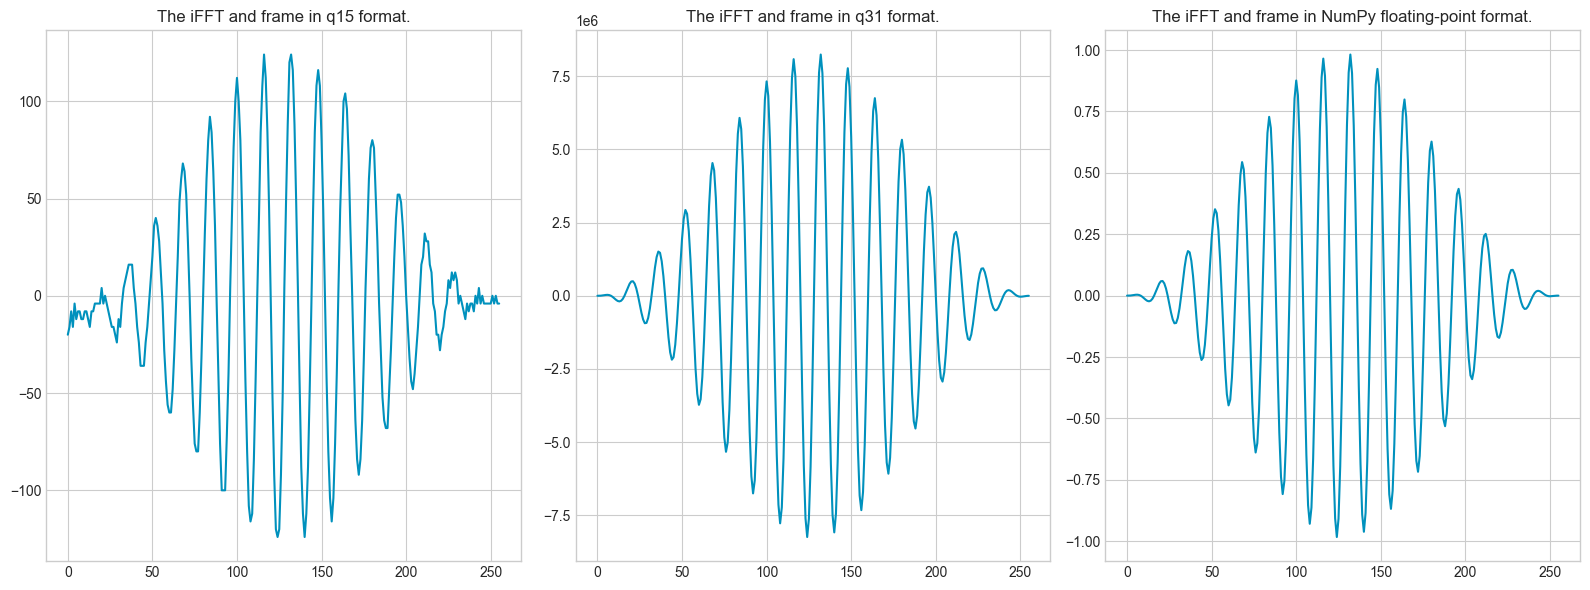

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(irfft_q15)
axes[1].plot(irfft_q31)
axes[2].plot(ifft_1)

axes[0].set_title("The iFFT and frame in q15 format.")
axes[1].set_title("The iFFT and frame in q31 format.")
axes[2].set_title("The iFFT and frame in NumPy floating-point format.")

fig.tight_layout()

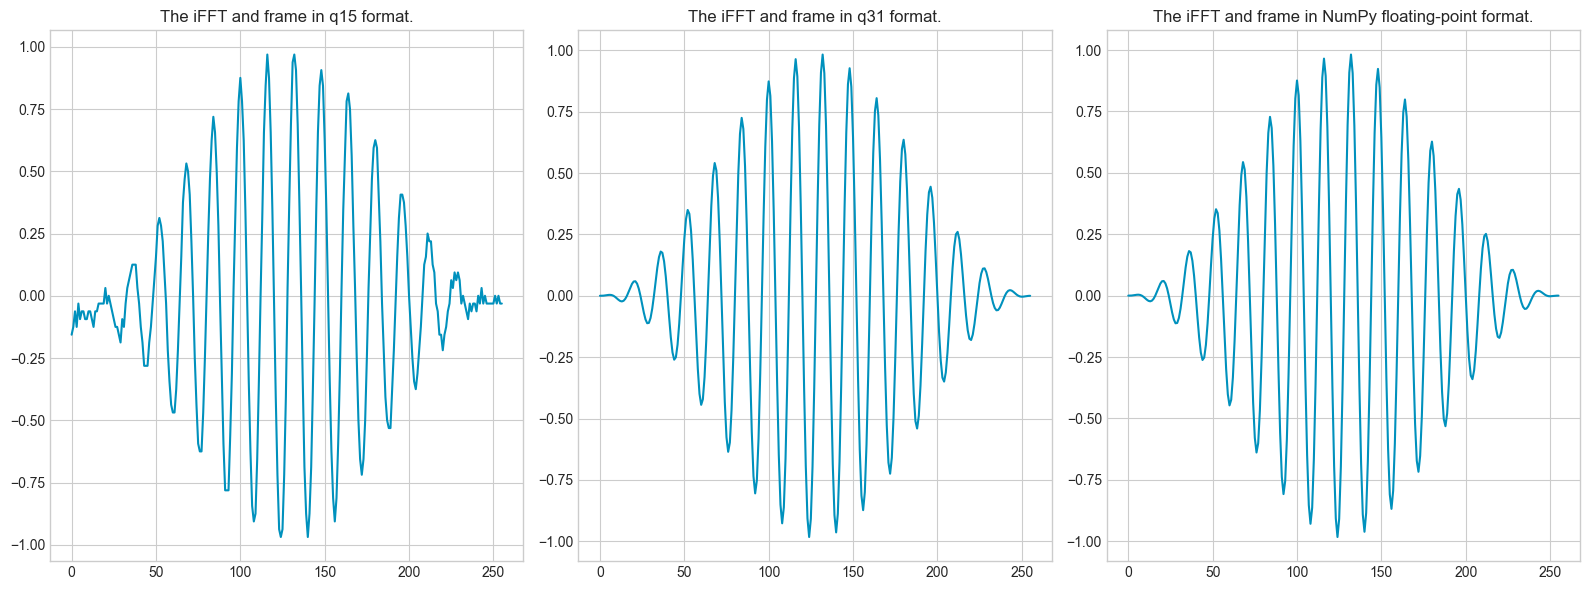

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(irfft_revert_q15)
axes[1].plot(irfft_revert_q31)
axes[2].plot(ifft_1)

axes[0].set_title("The iFFT and frame in q15 format.")
axes[1].set_title("The iFFT and frame in q31 format.")
axes[2].set_title("The iFFT and frame in NumPy floating-point format.")

fig.tight_layout()

In [45]:
# # normalized to 1
# scaled_rfft_q15_q8_8_half_norm = rfft_q15_half >> int(np.log2(window_size)-1) 
# scaled_rfft_q31_q8_24_half_norm = rfft_q31_half >> int(np.log2(window_size)-1)

# normalized to 0.5
scaled_rfft_q15_q8_8_half_norm = rfft_q15_half >> int(np.log2(window_size)) 
scaled_rfft_q31_q8_24_half_norm = rfft_q31_half >> int(np.log2(window_size))


# when size 256 - fft upscale 8
scaled_rfft_q15_q1_15_half_norm = scaled_rfft_q15_q8_8_half_norm << int(np.log2(window_size)) # scaled fft Q 8.8 -> Q 1.15
scaled_rfft_q31_q1_31_half_norm = scaled_rfft_q31_q8_24_half_norm << int(np.log2(window_size)) # scaled fft Q 8.24 -> Q 1.31

# when size 256 - fft upscale 8, normalized to 1
# scaled_rfft_q15_q1_15_half_norm = rfft_q15_half << 1 # scaled fft Q 8.8 -> Q 1.15
# scaled_rfft_q31_q1_31_half_norm = rfft_q31_half << 1 # scaled fft Q 8.24 -> Q 1.31

# when size 256 - fft upscale 8, normalized to 0.5
scaled_rfft_q15_q1_15_half_norm = rfft_q15_half # scaled fft Q 8.8 -> Q 1.15
scaled_rfft_q31_q1_31_half_norm = rfft_q31_half # scaled fft Q 8.24 -> Q 1.31

scaled_rfft_q15_q8_8_half_norm_scaled = arm_q15_to_float(scaled_rfft_q15_q8_8_half_norm) * 2**8
scaled_rfft_q31_q8_24_half_norm_scaled = arm_q31_to_float(scaled_rfft_q31_q8_24_half_norm) * 2**8

scaled_rfft_q15_q1_15_half_norm_scaled = arm_q15_to_float(scaled_rfft_q15_q1_15_half_norm)
scaled_rfft_q31_q1_31_half_norm_scaled = arm_q31_to_float(scaled_rfft_q31_q1_31_half_norm)

# amplitude
scaled_fft_bins_q15_q2_14_half_norm = arm_cmplx_mag_q15(scaled_rfft_q15_q1_15_half_norm)
scaled_fft_bins_q31_q2_30_half_norm = arm_cmplx_mag_q31(scaled_rfft_q31_q1_31_half_norm)

scaled_fft_bins_q15_q1_15_half_norm = scaled_fft_bins_q15_q2_14_half_norm << 1
scaled_fft_bins_q31_q1_31_half_norm = scaled_fft_bins_q31_q2_30_half_norm << 1

scaled_fft_bins_q15_q2_14_half_norm_scaled = arm_q15_to_float(scaled_fft_bins_q15_q2_14_half_norm) * 2 
scaled_fft_bins_q31_q2_30_half_norm_scaled = arm_q31_to_float(scaled_fft_bins_q31_q2_30_half_norm) * 2

scaled_fft_bins_q15_q1_15_half_norm_scaled = arm_q15_to_float(scaled_fft_bins_q15_q1_15_half_norm)
scaled_fft_bins_q31_q1_31_half_norm_scaled = arm_q31_to_float(scaled_fft_bins_q31_q1_31_half_norm)


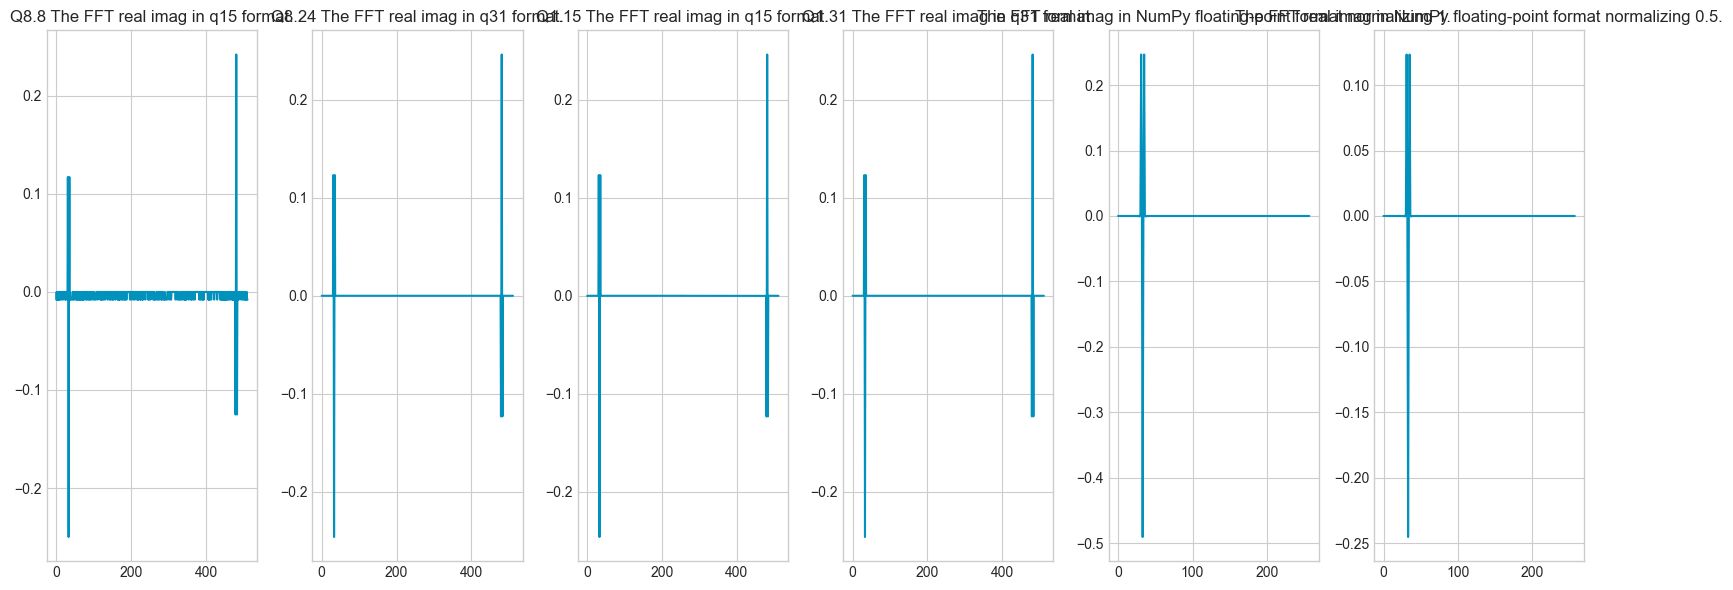

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 6))

axes[0].plot(scaled_rfft_q15_q8_8_half_norm_scaled)
axes[0].set_title("Q8.8 The FFT real imag in q15 format.")

axes[1].plot(scaled_rfft_q31_q8_24_half_norm_scaled)
axes[1].set_title("Q8.24 The FFT real imag in q31 format.")

axes[2].plot(scaled_rfft_q15_q1_15_half_norm_scaled)
axes[2].set_title("Q1.15 The FFT real imag in q15 format.")

axes[3].plot(scaled_rfft_q31_q1_31_half_norm_scaled)
axes[3].set_title("Q1.31 The FFT real imag in q31 format.")

axes[4].plot(rfft_float_half/(window_size/2))
axes[4].set_title("The FFT real imag in NumPy floating-point format normalizing 1.")

axes[5].plot(rfft_float_half/(window_size))
axes[5].set_title("The FFT real imag in NumPy floating-point format normalizing 0.5.")

fig.tight_layout()

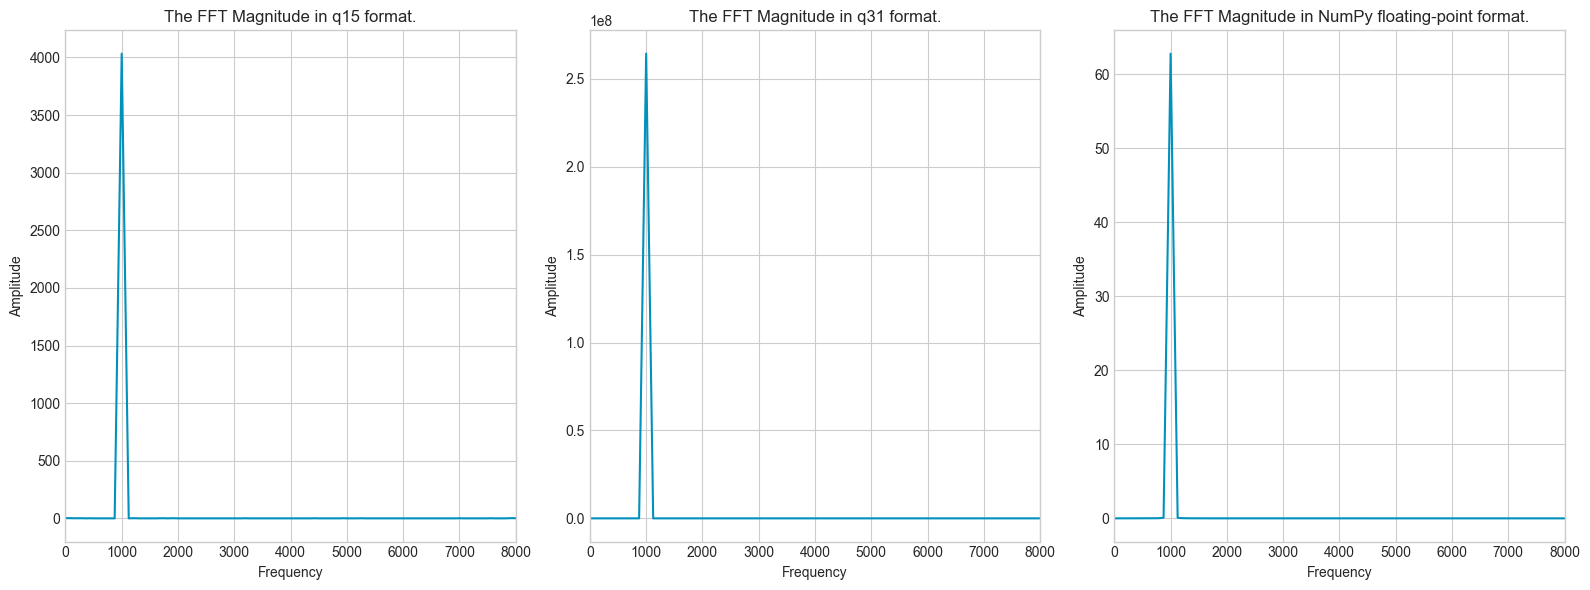

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(xf, fft_bins_q15)
axes[0].set_xlabel("Frequency")
axes[0].set_xlim([xf[0], xf[-1]])
axes[0].set_ylabel("Amplitude")
axes[0].set_title("The FFT Magnitude in q15 format.")

axes[1].plot(xf, fft_bins_q31)
axes[1].set_xlabel("Frequency")
axes[1].set_xlim([xf[0], xf[-1]])
axes[1].set_ylabel("Amplitude")
axes[1].set_title("The FFT Magnitude in q31 format.")

axes[2].plot(xf, fft_bins_1)
axes[2].set_xlabel("Frequency")
axes[2].set_xlim([xf[0], xf[-1]])
axes[2].set_ylabel("Amplitude")
axes[2].set_title("The FFT Magnitude in NumPy floating-point format.")

fig.tight_layout()


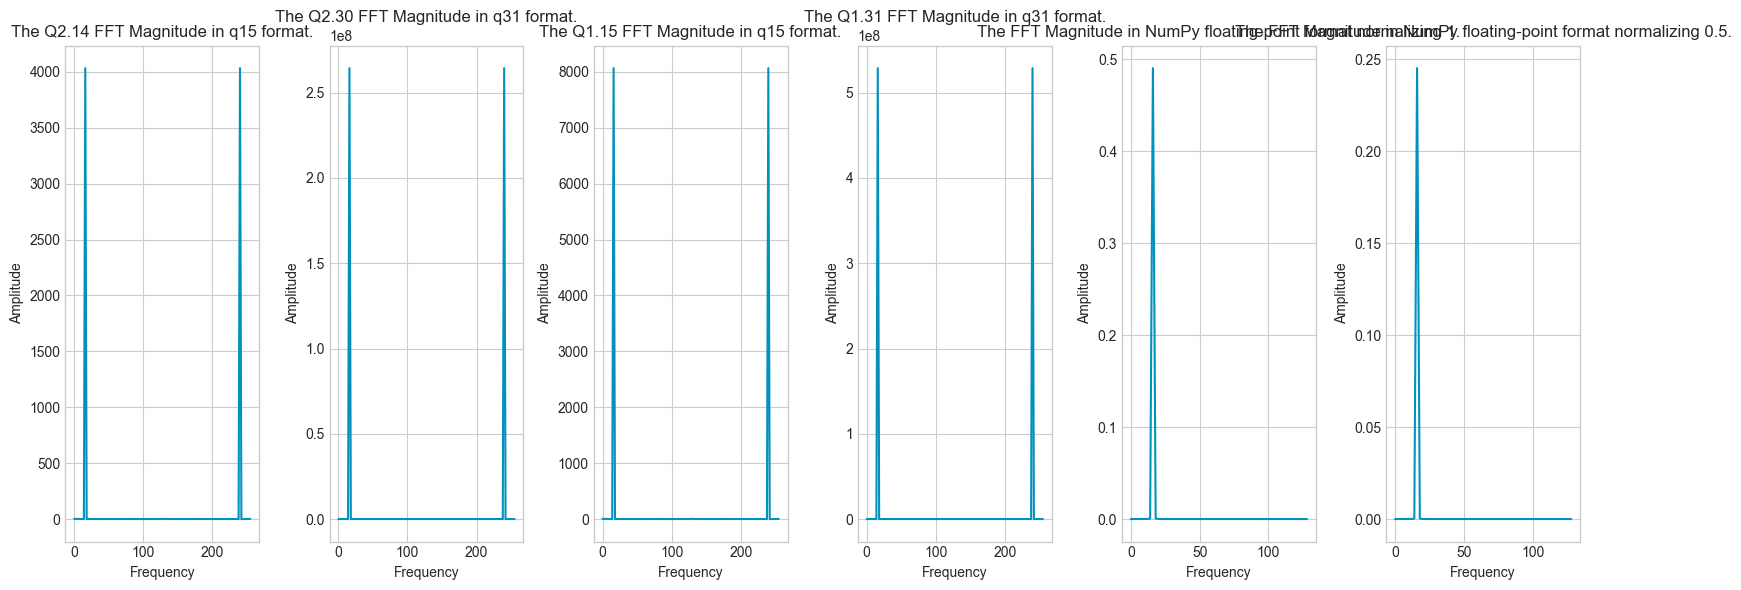

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 6))

axes[0].plot(scaled_fft_bins_q15_q2_14_half_norm)
axes[0].set_xlabel("Frequency")
# axes[0].set_xlim([xf[0], xf[-1]])
axes[0].set_ylabel("Amplitude")
axes[0].set_title("The Q2.14 FFT Magnitude in q15 format.")

axes[1].plot(scaled_fft_bins_q31_q2_30_half_norm)
axes[1].set_xlabel("Frequency")
# axes[1].set_xlim([xf[0], xf[-1]])
axes[1].set_ylabel("Amplitude")
axes[1].set_title("The Q2.30 FFT Magnitude in q31 format.")

axes[2].plot(scaled_fft_bins_q15_q1_15_half_norm)
axes[2].set_xlabel("Frequency")
# axes[2].set_xlim([xf[0], xf[-1]])
axes[2].set_ylabel("Amplitude")
axes[2].set_title("The Q1.15 FFT Magnitude in q15 format.")

axes[3].plot(scaled_fft_bins_q31_q1_31_half_norm)
axes[3].set_xlabel("Frequency")
# axes[3].set_xlim([xf[0], xf[-1]])
axes[3].set_ylabel("Amplitude")
axes[3].set_title("The Q1.31 FFT Magnitude in q31 format.")

axes[4].plot(fft_bins_1/(window_size/2))
axes[4].set_xlabel("Frequency")
# axes[4].set_xlim([xf[0], xf[-1]])
axes[4].set_ylabel("Amplitude")
axes[4].set_title("The FFT Magnitude in NumPy floating-point format normalizing 1.")

axes[5].plot(fft_bins_1/(window_size))
axes[5].set_xlabel("Frequency")
# axes[4].set_xlim([xf[0], xf[-1]])
axes[5].set_ylabel("Amplitude")
axes[5].set_title("The FFT Magnitude in NumPy floating-point format normalizing 0.5.")

fig.tight_layout()

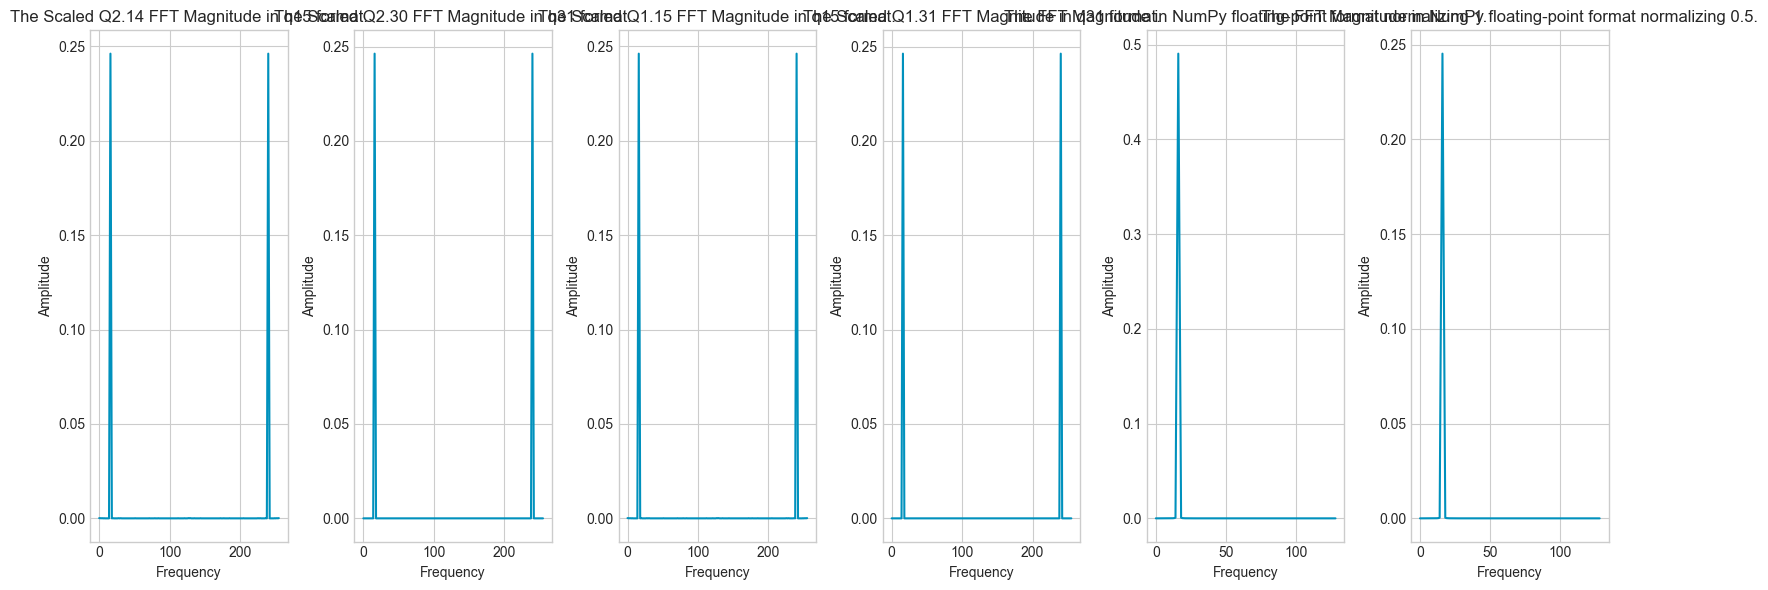

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 6))

axes[0].plot(scaled_fft_bins_q15_q2_14_half_norm_scaled)
axes[0].set_xlabel("Frequency")
# axes[0].set_xlim([xf[0], xf[-1]])
axes[0].set_ylabel("Amplitude")
axes[0].set_title("The Scaled Q2.14 FFT Magnitude in q15 format.")

axes[1].plot(scaled_fft_bins_q31_q2_30_half_norm_scaled)
axes[1].set_xlabel("Frequency")
# axes[1].set_xlim([xf[0], xf[-1]])
axes[1].set_ylabel("Amplitude")
axes[1].set_title("The Scaled Q2.30 FFT Magnitude in q31 format.")

axes[2].plot(scaled_fft_bins_q15_q1_15_half_norm_scaled)
axes[2].set_xlabel("Frequency")
# axes[2].set_xlim([xf[0], xf[-1]])
axes[2].set_ylabel("Amplitude")
axes[2].set_title("The Scaled Q1.15 FFT Magnitude in q15 format.")

axes[3].plot(scaled_fft_bins_q31_q1_31_half_norm_scaled)
axes[3].set_xlabel("Frequency")
# axes[3].set_xlim([xf[0], xf[-1]])
axes[3].set_ylabel("Amplitude")
axes[3].set_title("The Scaled Q1.31 FFT Magnitude in q31 format.")

axes[4].plot(fft_bins_1/(window_size/2))
axes[4].set_xlabel("Frequency")
# axes[4].set_xlim([xf[0], xf[-1]])
axes[4].set_ylabel("Amplitude")
axes[4].set_title("The FFT Magnitude in NumPy floating-point format normalizing 1.")

axes[5].plot(fft_bins_1/(window_size))
axes[5].set_xlabel("Frequency")
# axes[4].set_xlim([xf[0], xf[-1]])
axes[5].set_ylabel("Amplitude")
axes[5].set_title("The FFT Magnitude in NumPy floating-point format normalizing 0.5.")

fig.tight_layout()

In [55]:
# # Apply the FFT to the audio, noramlized value 1 -> 0.5 for ifft
# irfft_q15_q8_8 = arm_rfft_q15(irfft_instance_q15, scaled_rfft_q15_q1_15_half_norm>>1) 
# irfft_q31_q8_24 = arm_rfft_q31(irfft_instance_q31, scaled_rfft_q31_q1_31_half_norm>>1) 

# Apply the FFT to the audio, noramlized value 0.5 for ifft
irfft_q15_q8_8 = arm_rfft_q15(irfft_instance_q15, scaled_rfft_q15_q1_15_half_norm) 
irfft_q31_q8_24 = arm_rfft_q31(irfft_instance_q31, scaled_rfft_q31_q1_31_half_norm) 

irfft_q15_q1_15 = irfft_q15_q8_8 << int(np.log2(window_size)) # Q8.8 -> Q1.15
irfft_q31_q1_31 = irfft_q31_q8_24 << int(np.log2(window_size)) # Q8.24 -> Q1.31

irfft_revert_q15_q1_15 = arm_q15_to_float(irfft_q15_q1_15)
irfft_revert_q31_q1_31 = arm_q31_to_float(irfft_q31_q1_31)

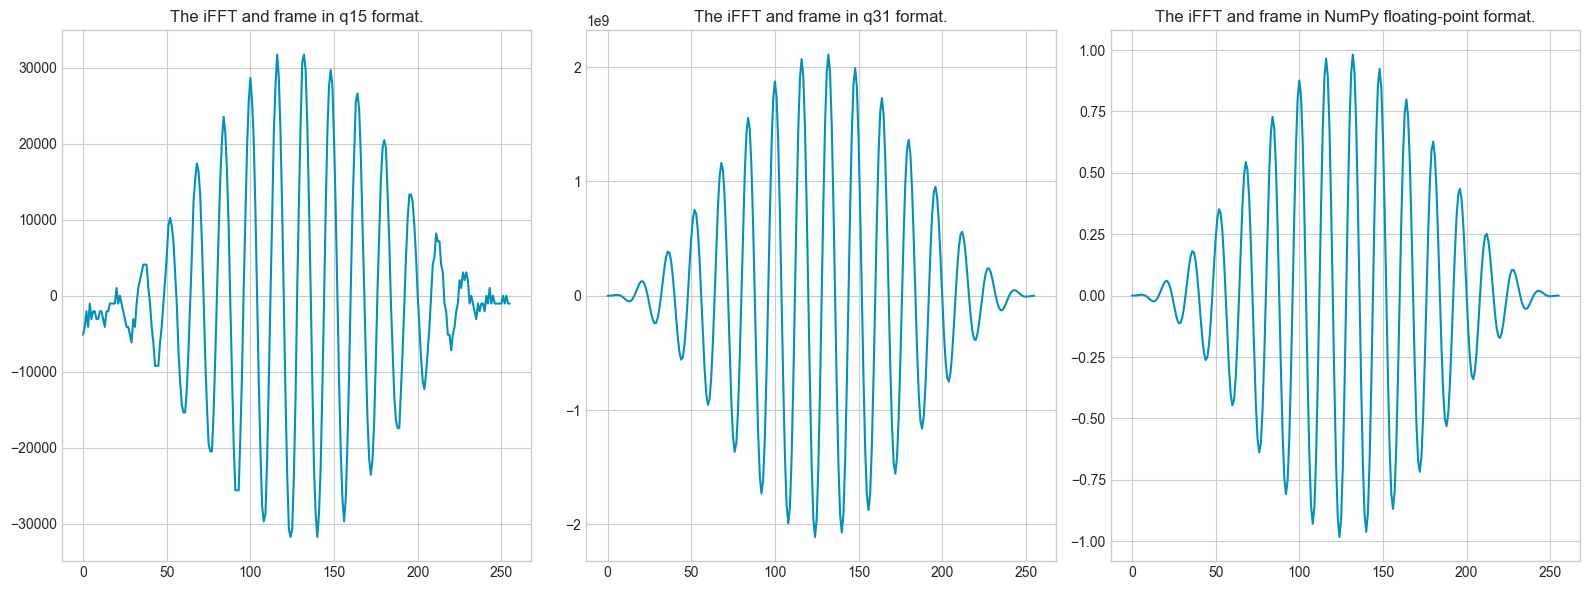

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))


axes[0].plot(irfft_q15_q1_15)
axes[1].plot(irfft_q31_q1_31)

# axes[0].plot(irfft_q15_q8_8)
# axes[1].plot(irfft_q31_q8_24)

axes[2].plot(ifft_1)

axes[0].set_title("The iFFT and frame in q15 format.")
axes[1].set_title("The iFFT and frame in q31 format.")
axes[2].set_title("The iFFT and frame in NumPy floating-point format.")

fig.tight_layout()

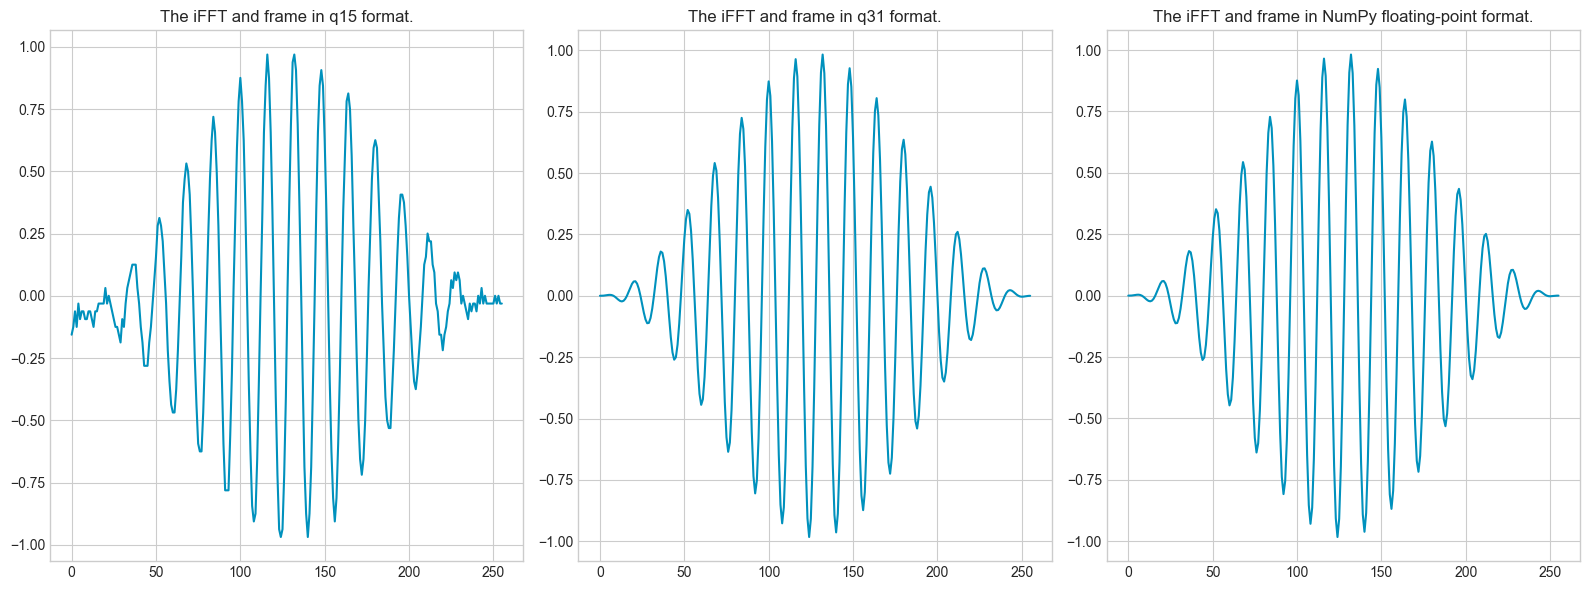

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

axes[0].plot(irfft_revert_q15_q1_15)
axes[1].plot(irfft_revert_q31_q1_31)
axes[2].plot(ifft_1)

# axes[0].plot(irfft_revert_q15)
# axes[1].plot(irfft_revert_q31)

axes[0].set_title("The iFFT and frame in q15 format.")
axes[1].set_title("The iFFT and frame in q31 format.")
axes[2].set_title("The iFFT and frame in NumPy floating-point format.")

fig.tight_layout()